# Import thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn

import os
from PIL import Image

from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import layers, models, Input
from keras.layers import Dense, Activation, Input, MaxPooling2D, Conv2D, BatchNormalization, \
    Flatten, Dropout, AveragePooling2D, Rescaling, concatenate, GlobalAveragePooling2D, ReLU, Add
from keras.models import Sequential, Model
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

2025-10-31 09:52:33.326448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761904353.520983      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761904353.568464      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = '/kaggle/input/ds201-lab2/VinaFood21/train'
test_dir = '/kaggle/input/ds201-lab2/VinaFood21/test'

# Bài 1.

## Load dữ liệu

In [33]:
X = []
y = []
class_names = sorted(os.listdir(train_dir))
print("Các lớp:", class_names)

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        try:
            with open(file_path, "rb") as f:
                img = Image.open(f).convert("RGB")  # ép tất cả về RGB (3 kênh)
                img = img.resize((28, 28))
                X.append(np.array(img))
                y.append(class_idx)
        except Exception as e:
            print(f"Lỗi đọc {file_path}: {e}")

X = np.array(X)
y = np.array(y)

print("Kích thước X:", X.shape)
print("Kích thước y:", y.shape)


Các lớp: ['banh-can', 'banh-hoi', 'banh-mi-chao', 'banh-tet', 'banh-trang-tron', 'banh-u', 'banh-uot', 'bap-nuong', 'bo-kho', 'bo-la-lot', 'bot-chien', 'ca-ri', 'canh-kho-qua', 'canh-khoai-mo', 'ga-nuong', 'goi-ga', 'ha-cao', 'hoanh-thanh-nuoc', 'pha-lau', 'tau-hu', 'thit-kho-trung']
Kích thước X: (10044, 28, 28, 3)
Kích thước y: (10044,)


In [34]:
X_test = []
y_test = []
class_names = sorted(os.listdir(test_dir))
print("Các lớp:", class_names)

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        try:
            with open(file_path, "rb") as f:
                img = Image.open(f).convert("RGB")  # ép tất cả về RGB (3 kênh)
                img = img.resize((28, 28))
                X_test.append(np.array(img))
                y_test.append(class_idx)
        except Exception as e:
            print(f"Lỗi đọc {file_path}: {e}")

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Kích thước X:", X_test.shape)
print("Kích thước y:", y_test.shape)

Các lớp: ['banh-can', 'banh-hoi', 'banh-mi-chao', 'banh-tet', 'banh-trang-tron', 'banh-u', 'banh-uot', 'bap-nuong', 'bo-kho', 'bo-la-lot', 'bot-chien', 'ca-ri', 'canh-kho-qua', 'canh-khoai-mo', 'ga-nuong', 'goi-ga', 'ha-cao', 'hoanh-thanh-nuoc', 'pha-lau', 'tau-hu', 'thit-kho-trung']
Kích thước X: (6682, 28, 28, 3)
Kích thước y: (6682,)


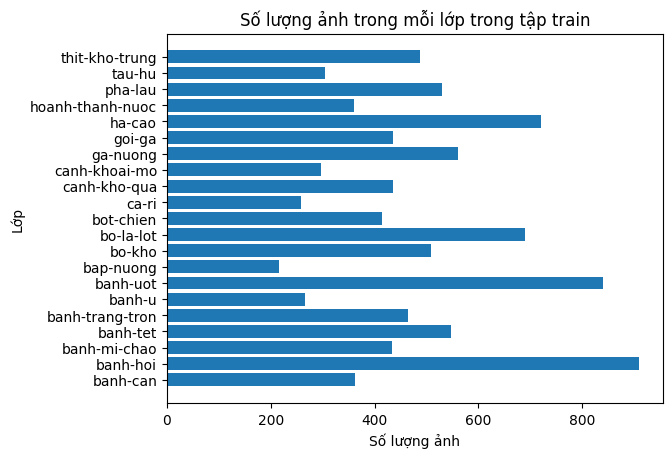

In [35]:
unique, counts = np.unique(y, return_counts=True)

plt.barh(class_names, counts)
plt.title("Số lượng ảnh trong mỗi lớp trong tập train")
plt.ylabel("Lớp")
plt.xlabel("Số lượng ảnh")
plt.show()

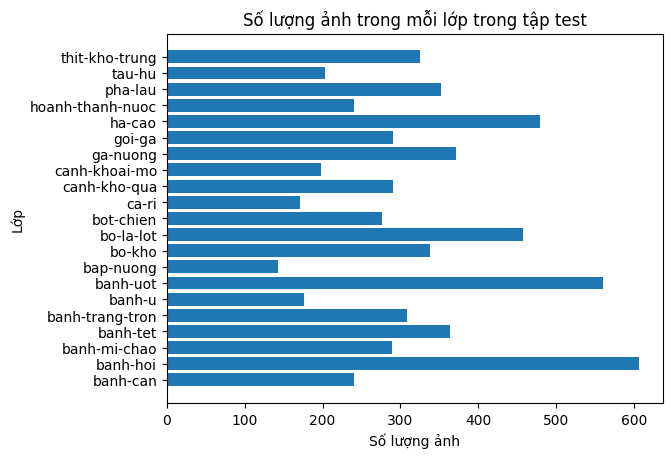

In [36]:
unique, counts = np.unique(y_test, return_counts=True)

plt.barh(class_names, counts)
plt.title("Số lượng ảnh trong mỗi lớp trong tập test")
plt.ylabel("Lớp")
plt.xlabel("Số lượng ảnh")
plt.show()

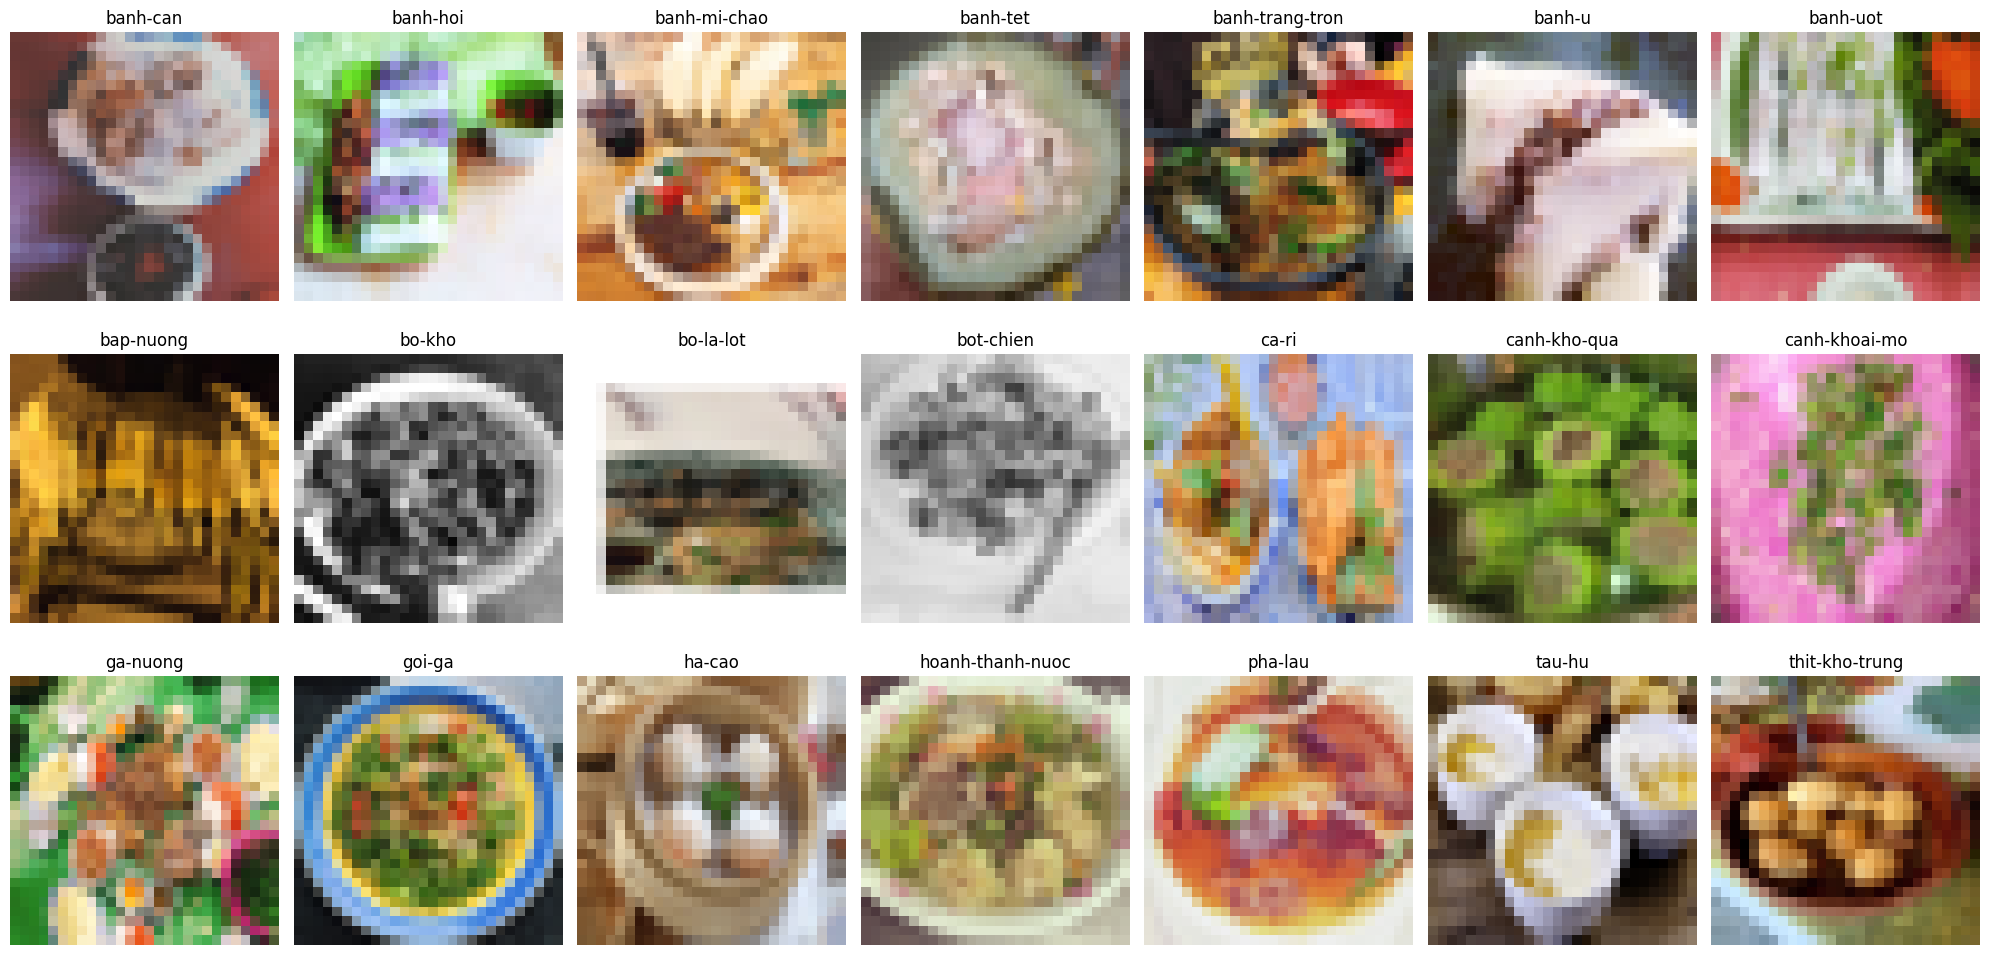

In [37]:
rows, cols = 3, 7
total = rows * cols

unique_classes = np.unique(y)
n_classes = len(unique_classes)
num_to_show = min(n_classes, total)

plt.figure(figsize=(20, 10))
for i in range(num_to_show):
    cls = unique_classes[i]
    idx = np.where(y == cls)[0][0]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[idx].astype(np.uint8), cmap="gray")
    plt.title(class_names[cls], fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
y_train_new = to_categorical(y_train, num_classes = 21)
y_val_new = to_categorical(y_val, num_classes = 21)

## Xây dựng và huấn luyện mô hình

In [40]:
model_LeNet = Sequential([
    Conv2D(6, (5, 5), activation='relu', padding= 'same', input_shape=(28, 28, 3)),
    AveragePooling2D(strides=2, pool_size = (2, 2)),
    
    Conv2D(16, (5, 5), activation='relu', padding='valid'),
    AveragePooling2D(strides=2, pool_size = (2, 2)),

    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation = 'relu'),
    Dense(21, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
Optimizer = Adam(learning_rate=1e-3)
Loss = CategoricalCrossentropy()
model_LeNet.compile(optimizer=Optimizer, loss=Loss, metrics=['accuracy'])

In [42]:
history_4 = model_LeNet.fit(X_train, y_train_new, 
                        validation_data=(X_val, y_val_new),
                        batch_size=64, epochs=30)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.0748 - loss: 9.9482 - val_accuracy: 0.1210 - val_loss: 2.8826
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1449 - loss: 2.8359 - val_accuracy: 0.1628 - val_loss: 2.7726
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1843 - loss: 2.6852 - val_accuracy: 0.1762 - val_loss: 2.7291
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2372 - loss: 2.5359 - val_accuracy: 0.1931 - val_loss: 2.6480
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2791 - loss: 2.3985 - val_accuracy: 0.2150 - val_loss: 2.6369
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3170 - loss: 2.2922 - val_accuracy: 0.2165 - val_loss: 2.6424
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3480 - loss: 2.1356 - val_accuracy: 0.2339 - val_loss: 2.6113
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3935 - loss: 2.0085 - val_accuracy: 0

## Đánh giá

In [43]:
y_pred = model_LeNet.predict(X_test)
y_pred = np.argmax(y_pred, axis = -1)
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred, average='macro')*100,2)
recall = round(recall_score(y_test, y_pred, average='macro')*100,2)
f1 = round(f1_score(y_test, y_pred, average='macro')*100,2)
print('Accuracy test = {}%'.format(accuracy))
print('Precision test = {}%'.format(precision))
print('Recall test = {}%'.format(recall))
print('F1-macro test = {}%'.format(f1))

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy test = 19.84%
Precision test = 18.88%
Recall test = 18.78%
F1-macro test = 18.61%


# Bài 2.

Do GoogLeNet và ResNet hoạt động tốt với input = (224, 224, 3) và các hình ảnh 28x28x3 khi show ở bài một độ phân giải yếu. Nên load lại data với shape 224x224

## Load dữ liệu

In [3]:
X = []
y = []
class_names = sorted(os.listdir(train_dir))
print("Các lớp:", class_names)

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        try:
            with open(file_path, "rb") as f:
                img = Image.open(f).convert("RGB")  # ép tất cả về RGB (3 kênh)
                img = img.resize((224, 224))
                X.append(np.array(img))
                y.append(class_idx)
        except Exception as e:
            print(f"Lỗi đọc {file_path}: {e}")

X = np.array(X)
y = np.array(y)

print("Kích thước X:", X.shape)
print("Kích thước y:", y.shape)


Các lớp: ['banh-can', 'banh-hoi', 'banh-mi-chao', 'banh-tet', 'banh-trang-tron', 'banh-u', 'banh-uot', 'bap-nuong', 'bo-kho', 'bo-la-lot', 'bot-chien', 'ca-ri', 'canh-kho-qua', 'canh-khoai-mo', 'ga-nuong', 'goi-ga', 'ha-cao', 'hoanh-thanh-nuoc', 'pha-lau', 'tau-hu', 'thit-kho-trung']


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Kích thước X: (10044, 224, 224, 3)
Kích thước y: (10044,)


In [4]:
X_test = []
y_test = []
class_names = sorted(os.listdir(test_dir))
print("Các lớp:", class_names)

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        try:
            with open(file_path, "rb") as f:
                img = Image.open(f).convert("RGB")  # ép tất cả về RGB (3 kênh)
                img = img.resize((224, 224))
                X_test.append(np.array(img))
                y_test.append(class_idx)
        except Exception as e:
            print(f"Lỗi đọc {file_path}: {e}")

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Kích thước X:", X_test.shape)
print("Kích thước y:", y_test.shape)

Các lớp: ['banh-can', 'banh-hoi', 'banh-mi-chao', 'banh-tet', 'banh-trang-tron', 'banh-u', 'banh-uot', 'bap-nuong', 'bo-kho', 'bo-la-lot', 'bot-chien', 'ca-ri', 'canh-kho-qua', 'canh-khoai-mo', 'ga-nuong', 'goi-ga', 'ha-cao', 'hoanh-thanh-nuoc', 'pha-lau', 'tau-hu', 'thit-kho-trung']
Kích thước X: (6682, 224, 224, 3)
Kích thước y: (6682,)


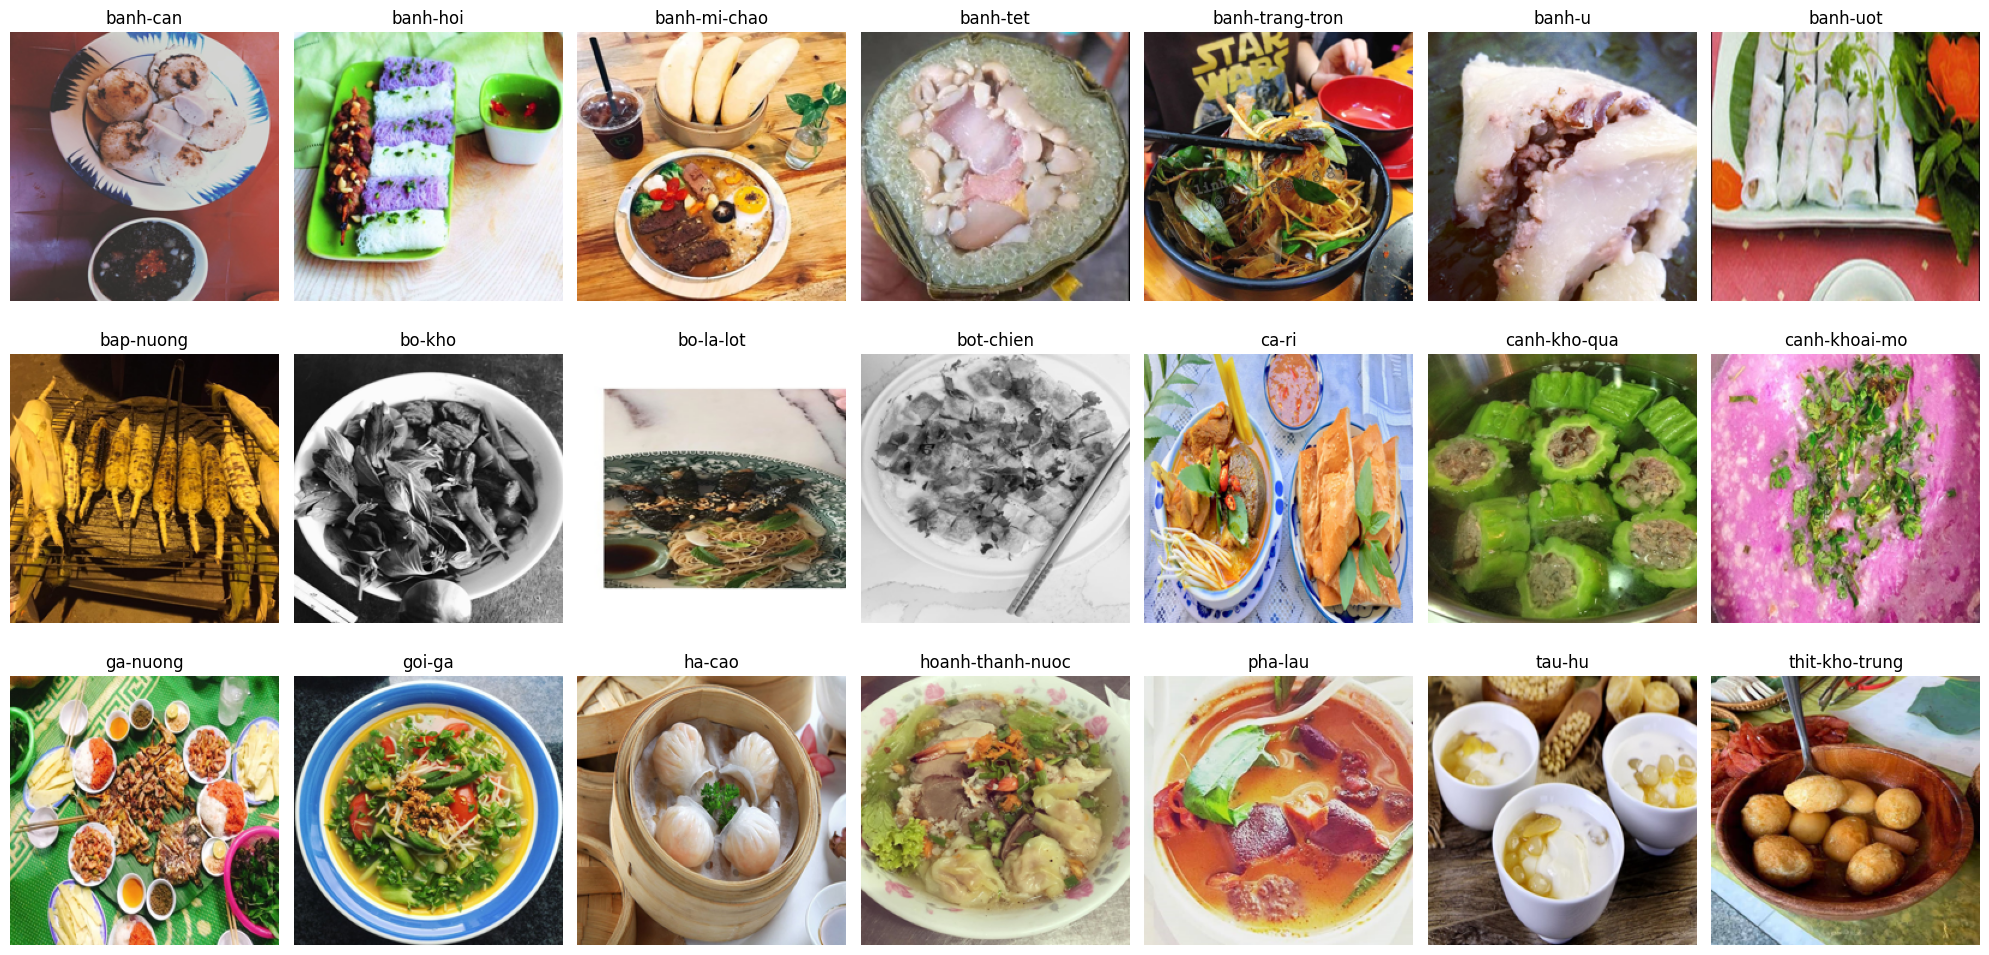

In [14]:
rows, cols = 3, 7
total = rows * cols

unique_classes = np.unique(y)
n_classes = len(unique_classes)
num_to_show = min(n_classes, total)

plt.figure(figsize=(20, 10))
for i in range(num_to_show):
    cls = unique_classes[i]
    idx = np.where(y == cls)[0][0]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[idx].astype(np.uint8), cmap="gray")
    plt.title(class_names[cls], fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_new = to_categorical(y_train, num_classes = 21)
y_val_new = to_categorical(y_val, num_classes = 21)

## Xây dựng và huấn luyện mô hình

In [54]:
def inception_block(x, filters):
    f1, f3In, f3O, f5In, f5O, fp = filters

    branch1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)

    branch2 = Conv2D(f3In, (1,1), padding='same', activation='relu')(x)
    branch2 = Conv2D(f3O, (3,3), padding='same', activation='relu')(branch2)

    branch3 = Conv2D(f5In, (1,1), padding='same', activation='relu')(x)
    branch3 = Conv2D(f5O, (5,5), padding='same', activation='relu')(branch3)

    branch4 = MaxPooling2D((3,3), strides=1, padding='same')(x)
    branch4 = Conv2D(fp, (1,1), padding='same', activation='relu')(branch4)

    x = concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return x


def myGoogLeNet(input_shape=(224,224,3), num_classes=21):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (1,1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = inception_block(x, (64, 96, 128, 16, 32, 32))   
    x = inception_block(x, (128, 128, 192, 32, 96, 64)) 
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = inception_block(x, (192, 96, 208, 16, 48, 64))  
    x = inception_block(x, (160, 112, 224, 24, 64, 64)) 
    x = inception_block(x, (128, 128, 256, 24, 64, 64)) 
    x = inception_block(x, (112, 144, 288, 32, 64, 64)) 
    x = inception_block(x, (256, 160, 320, 32, 128, 128)) 
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = inception_block(x, (256, 160, 320, 32, 128, 128)) 
    x = inception_block(x, (384, 192, 384, 48, 128, 128)) 

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name='GoogLeNet_v1')
    return model

In [55]:
model_googlenet = myGoogLeNet(input_shape=(224, 224, 3), num_classes=21)

model_googlenet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [56]:
model_googlenet.summary()


Model: "GoogLeNet_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 56, 56,    │          0 │ conv2d_136[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d_27… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 56, 56,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 56, 56,    │    110,784 │ conv2d_137[0][0]  │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_138[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (None, 28, 28,    │     18,528 │ max_pooling2d_28… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 28, 28,    │      3,088 │ max_pooling2d_28… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 28, 28,    │          0 │ max_pooling2d_28… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 28, 28,    │     12,352 │ max_pooling2d_28… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 28, 28,    │    110,720 │ conv2d_140[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 28, 28,    │     12,832 │ conv2d_142[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 28, 28,    │      6,176 │ max_pooling2d_29… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 28, 28,    │          0 │ conv2d_139[0][0], │
│ (Concatenate)       │ 256)              │            │ conv2d_141[0][0], │
│                     │                   │            │ conv2d_143[0][0], │
│                     │                   │            │ conv2d_144[0][0]

 Total params: 5,996,101 (22.87 MB)

 Trainable params: 5,995,589 (22.87 MB)

 Non-trainable params: 512 (2.00 KB)

In [57]:
history_2 = model_googlenet.fit(X_train, y_train_new, 
                                validation_data=(X_val, y_val_new),
                                batch_size=32, epochs=20)

Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.0838 - loss: 3.0005 - val_accuracy: 0.0941 - val_loss: 2.9064
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.1125 - loss: 2.8245 - val_accuracy: 0.1015 - val_loss: 2.9697
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.1431 - loss: 2.7045 - val_accuracy: 0.0931 - val_loss: 3.0848
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.1802 - loss: 2.5578 - val_accuracy: 0.1155 - val_loss: 2.8825
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.1982 - loss: 2.4912 - val_accuracy: 0.1712 - val_loss: 2.9043
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.2138 - loss: 2.4467 - val_accuracy: 0.1976 - val_loss: 2.5910
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.2486 - loss: 2.3344 - val_accuracy: 0.2111 - val_loss: 2.5787
Epoch 8/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.2939 - loss: 2.2306 -

## Đánh giá

In [58]:
y_pred = model_googlenet.predict(X_test)
y_pred = np.argmax(y_pred, axis = -1)
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred, average='macro')*100,2)
recall = round(recall_score(y_test, y_pred, average='macro')*100,2)
f1 = round(f1_score(y_test, y_pred, average='macro')*100,2)
print('Accuracy test = {}%'.format(accuracy))
print('Precision test = {}%'.format(precision))
print('Recall test = {}%'.format(recall))
print('F1 test = {}%'.format(f1))

209/209 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step
Accuracy test = 40.56%
Precision test = 41.36%
Recall test = 39.29%
F1 test = 36.29%


# Bài 3: 

## Xây dựng và huấn luyện mô hình

In [59]:
def residual_block(x, filters, stride=1):
    shortcut = x

    # First conv
    x = Conv2D(filters, (3,3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second conv
    x = Conv2D(filters, (3,3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1,1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


def ResNet18(input_shape=(224,224,3), num_classes=21):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    # conv2_x
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # conv3_x
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    # conv4_x
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    # conv5_x
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    # Head
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name='ResNet18')
    return model


# Tạo và compile model
model_resnet18 = ResNet18(input_shape=(224,224,3), num_classes=21)
model_resnet18.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet18.summary()


Model: "ResNet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_193 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_193[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_40    │ (None, 56, 56,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_194 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_40… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_194[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_195 (Conv2D) │ (None, 56, 56,    │     36,864 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_195[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_40… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 56, 56,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_19[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_196[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_197 (Conv2D) │ (None, 56, 56,    │     36,864 │ re_lu_20[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_197[0][0]

 Total params: 11,199,765 (42.72 MB)

 Trainable params: 11,190,165 (42.69 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [60]:
history_3 = model_resnet18.fit(X_train, y_train_new, 
                               validation_data=(X_val, y_val_new),
                               batch_size=64, epochs=20)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 182ms/step - accuracy: 0.1590 - loss: 3.0447 - val_accuracy: 0.0353 - val_loss: 12.1925
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.2504 - loss: 2.4386 - val_accuracy: 0.1583 - val_loss: 3.1505
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.3041 - loss: 2.2667 - val_accuracy: 0.0767 - val_loss: 11.9464
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.3689 - loss: 2.0276 - val_accuracy: 0.1020 - val_loss: 6.3936
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.3956 - loss: 1.9519 - val_accuracy: 0.1200 - val_loss: 3.9779
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.4190 - loss: 1.8580 - val_accuracy: 0.2225 - val_loss: 3.7443
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.4648 - loss: 1.7286 - val_accuracy: 0.1324 - val_loss: 4.4765
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.5033 - loss:

## Đánh giá

In [61]:
y_pred = model_resnet18.predict(X_test)
y_pred = np.argmax(y_pred, axis = -1)
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred, average='macro')*100,2)
recall = round(recall_score(y_test, y_pred, average='macro')*100,2)
f1 = round(f1_score(y_test, y_pred, average='macro')*100,2)
print('Accuracy test = {}%'.format(accuracy))
print('Precision test = {}%'.format(precision))
print('Recall test = {}%'.format(recall))
print('F1 test = {}%'.format(f1))

209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
Accuracy test = 43.36%
Precision test = 54.32%
Recall test = 39.36%
F1 test = 39.49%


# Bài 4.

In [6]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import ResNetForImageClassification, AutoImageProcessor
from tqdm import tqdm
import numpy as np

## Tạo Dataloader

In [7]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
def preprocess(X):
    tensors = []
    for img in X:
        inputs = processor(images=img, return_tensors="pt")
        tensors.append(inputs["pixel_values"])
    return torch.cat(tensors, dim=0)

# Convert dữ liệu
X_train_t = preprocess(X_train)
X_val_t = preprocess(X_val)
X_test_t  = preprocess(X_test)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

In [9]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

## Khởi tạo và huấn luyện mô hình

In [11]:
class PretrainedResnet(nn.Module):
    def __init__(self):
        super().__init__()

        basemodel = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

        self.resnet = basemodel.resnet
        self.classifier = nn.Linear(in_features=2048, out_features=21, bias=True)

    def forward(self, images: torch.Tensor):
        features = self.resnet(images).pooler_output
        features = features.squeeze(-1).squeeze(-1)
        logits = self.classifier(features)

        return logits

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PretrainedResnet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Acc: {acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 503/503 [00:49<00:00, 10.15it/s]


Train Loss: 2.5719, Acc: 0.2446
Val Loss: 1.6969, Val Acc: 0.5709


Epoch 2/5: 100%|██████████| 503/503 [00:48<00:00, 10.45it/s]


Train Loss: 1.2707, Acc: 0.6551
Val Loss: 0.8169, Val Acc: 0.7631


Epoch 3/5: 100%|██████████| 503/503 [00:48<00:00, 10.46it/s]


Train Loss: 0.7274, Acc: 0.7826
Val Loss: 0.6039, Val Acc: 0.8109


Epoch 4/5: 100%|██████████| 503/503 [00:48<00:00, 10.46it/s]


Train Loss: 0.4985, Acc: 0.8531
Val Loss: 0.5055, Val Acc: 0.8402


Epoch 5/5: 100%|██████████| 503/503 [00:48<00:00, 10.47it/s]


Train Loss: 0.3575, Acc: 0.8956
Val Loss: 0.4866, Val Acc: 0.8447


In [13]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred, average='macro')*100,2)
recall = round(recall_score(y_test, y_pred, average='macro')*100,2)
f1 = round(f1_score(y_test, y_pred, average='macro')*100,2)

print('Accuracy test = {}%'.format(accuracy))
print('Precision test = {}%'.format(precision))
print('Recall test = {}%'.format(recall))
print('F1-macro test = {}%'.format(f1))

Evaluating on Test Set: 100%|██████████| 418/418 [00:11<00:00, 35.24it/s]

Accuracy test = 82.01%
Precision test = 82.08%
Recall test = 82.05%
F1-macro test = 81.76%
